## Train a stardist 2D model 

This notebook trains a stardist 2d model.  Before running this notebook a set of patches must exist in the following format.

1.  Ground Truth are put in a directory called ```/ground truth0```
2.  Inputs are put in a directory called ```inputn``` where n is an integer 0...m and represents the channel.  Note:  RGB images may only have one 'channel' directory.
3.  In each of the both directories there exist a set of files of the same names.  For example if in the ```inputn``` directory we have ```apples0```, ```apples1```, ```apples2``` label images of the same name must exist in the ```ground truthn``` directory.  

In [2]:
import os
from tnia.plotting.plt_helper import imshow_multi2d
import tensorflow as tf

## Check what devices we have access to....

It's sometimes not as important to have a beefy GPU for 2D as it is for 3D, but let's check.  (depending on the number of training patch size, channels and number of rays we use we may need a good GPU)

In [3]:
visible_devices = tf.config.list_physical_devices()
print(visible_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load inputs and ground truth

We load directories called 'input0' and 'ground truth0' which should exist under ```train_path```.  The reason we append '0' to the end of the name is because some of the code that generates image and label sets is meant to work on multiple channels (so the 0 is the channel number)

In [4]:
parent_path=r'D:\images\tnia-python-images\imagesc\2023_12_12_segmenting_etching_pits'

train_path = os.path.join(parent_path, 'labels')

image_patch_path = train_path + '/ground truth0'
label_patch_path = train_path + '/input0'

model_path = parent_path + r'\model'

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

## Use a helper to collect the training data

The helper will also normalize the inputs.

In [5]:
from tnia.deeplearning.dl_helper import collect_training_data
X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, add_trivial_channel=False)

print('Number of input images', len(X))
print('Number of ground truth images ', len(Y))

print('Size of first input image', X[0].shape)
print('Size of first ground truth image ', Y[0].shape)

Number of input images 7
Number of ground truth images  7
Size of first input image (256, 256)
Size of first ground truth image  (256, 256)


## Inspect images

Output training data shapes and plot images to make sure image and label set look OK 

(256, 256) (256, 256)
-0.0546875 1.453125


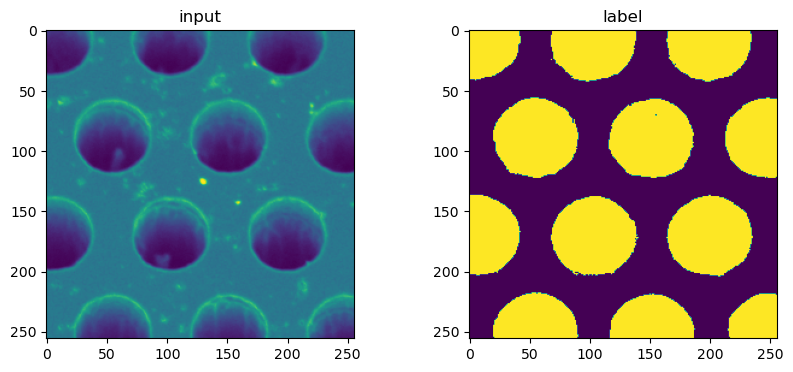

In [6]:

print(X[0].shape, Y[0].shape)
print(X[0].min(), X[0].max())
fig=imshow_multi2d([X[2], Y[2]], ['input', 'label'], 1,2)

## Divide in to training and validation sets

Use a helper to divide into training and validation.  Note the conversion to numpy arrays (needed for stardist training) is also baked into the divide_training_data function

In [7]:
from tnia.deeplearning.dl_helper import divide_training_data

X_train, Y_train, X_val, Y_val = divide_training_data(X, Y, val_size=2)

print('type X_train ', type(X_train))
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

type X_train  <class 'numpy.ndarray'>
(5, 256, 256) (2, 256, 256) (5, 256, 256) (2, 256, 256)


## Create stardist model

In [8]:
from stardist.models import StarDist2D, Config2D
from tnia.deeplearning.dl_helper import augmenter

n_channel_in = 1
axes = 'YX'

config = Config2D (n_rays=32, axes=axes,n_channel_in=n_channel_in, train_patch_size = (256,256), unet_n_depth=4)

new_model = False
if new_model == False:
    model = StarDist2D(config=None, name="model1", basedir=model_path)
else:
    model = StarDist2D(config=config, name="model1", basedir=model_path)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.408895, nms_thresh=0.3.


In [9]:
print(config)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(1, 1), backbone='unet', n_classes=None, unet_n_depth=4, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

## Train the model

In [39]:
model.train(X_train, Y_train,validation_data=(X_val, Y_val), epochs=100, steps_per_epoch=100, augmenter=augmenter)

Epoch 1/100
100/100 [==============================] - 33s 307ms/step - loss: 2.3782 - prob_loss: 0.3882 - dist_loss: 9.9501 - prob_kld: 0.2532 - dist_relevant_mae: 9.9494 - dist_relevant_mse: 173.0949 - dist_dist_iou_metric: 0.1762 - val_loss: 1.9091 - val_prob_loss: 0.3619 - val_dist_loss: 7.7362 - val_prob_kld: 0.1992 - val_dist_relevant_mae: 7.7354 - val_dist_relevant_mse: 121.0621 - val_dist_dist_iou_metric: 0.2023 - lr: 3.0000e-04
Epoch 2/100
100/100 [==============================] - 30s 302ms/step - loss: 1.7122 - prob_loss: 0.3432 - dist_loss: 6.8451 - prob_kld: 0.2070 - dist_relevant_mae: 6.8439 - dist_relevant_mse: 90.8575 - dist_dist_iou_metric: 0.3310 - val_loss: 1.7245 - val_prob_loss: 0.3661 - val_dist_loss: 6.7920 - val_prob_kld: 0.2035 - val_dist_relevant_mae: 6.7910 - val_dist_relevant_mse: 94.4617 - val_dist_dist_iou_metric: 0.3085 - lr: 3.0000e-04
Epoch 3/100
100/100 [==============================] - 30s 298ms/step - loss: 1.6694 - prob_loss: 0.3300 - dist_loss: 6.

In [21]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:00<00:00, 22.31it/s, 0.815 -> 0.218]


Using optimized values: prob_thresh=0.812629, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.8126290398639351, 'nms': 0.3}

## Test network on one of the training images (self prediction)

Self prediction is not a good way to evaluate the 'real' performance of the NN.  However it is good sanity test.  If the self prediction looks wrong something really went bad. 

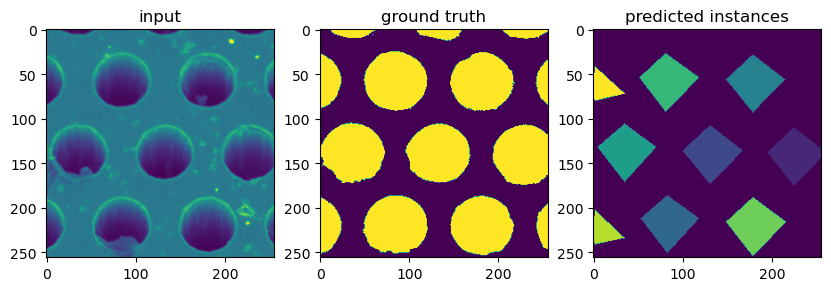

In [10]:
n=2
labels, details = model.predict_instances(X_train[n], prob_thresh=0.4, nms_thresh=0.3)
fig = imshow_multi2d([X_train[n],Y_train[n],labels],['input','ground truth','predicted instances'],1,3)


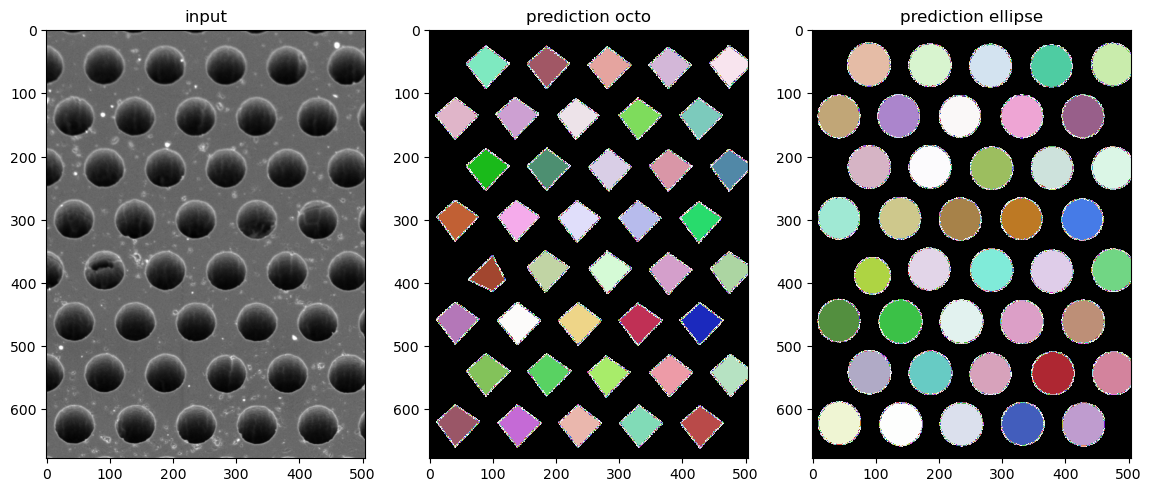

In [13]:
from skimage.io import imread
from tnia.plotting.plt_helper import random_label_cmap
from tnia.deeplearning.dl_helper import ray4_to_ellipsoid2d_labels
from csbdeep.utils import normalize

testim = imread(parent_path + r'\test.tif')
testim = normalize(testim,1,99.8, axis=(0,1))
labels, details = model.predict_instances(testim, prob_thresh=0.5, nms_thresh=0.1)
labels2 = ray4_to_ellipsoid2d_labels(details['coord'], testim.shape)

fig = imshow_multi2d([testim,labels, labels2],['input','prediction octo','prediction ellipse'],1,3, width=14, height=8,colormaps=['gray', random_label_cmap(), random_label_cmap()])


## View in Napari

In [14]:
import napari

viewer = napari.Viewer()
viewer.add_image(testim, name='testim')
viewer.add_labels(labels2, name='labels')

napari.manifest -> 'napari-hello' could not be imported: Cannot find module 'napari_plugins' declared in entrypoint: 'napari_plugins:napari.yaml'


<Labels layer 'labels' at 0x133cd2b2c40>

In [17]:
from skimage.io import imsave

label_name = parent_path + r'/labels_cycle3.tif'
imsave(label_name, labels.astype('uint16'))

264163233.py (4): D:\images\tnia-python-images\forum\bees/labels_cycle3.tif is a low contrast image
